Se importan las siguiente librerías:
- pandas: para poder cargar el dataset
- numpy: para poder manipular los arreglos y usar vectorización
- matplotlib: para graficar
- sklearn: para poder usar el label encoding, estandarizar, one-hot encoding y calcular las métricas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from scipy.special import softmax

Se cargan los datos del dataset.

In [3]:
df = pd.read_csv('zoo.csv')
df.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


Función para dividir el datasaet en subconjuntos.

In [4]:
def validate(partitions: tuple[int, ...], X = np.array, Y = np.array):
  assert type(partitions) == tuple, 'Partitions must be a tuple of ints'
  assert sum(partitions) == 100, 'Sum of paritions must be 100'
  assert type(X) == np.ndarray, 'X must be a NDArray'
  assert type(Y) == np.ndarray, 'X must be a NDArray'
  assert X.shape[0] == Y.shape[0], f'X and Y must have the same dimension'

def split_sequencial (partitions: tuple[int, ...], X = np.array, Y = np.array):
  validate(partitions, X, Y)

  length = X.shape[0]
  start_index = 0
  for partition in partitions:
    step = round(partition / 100 * length)
    end_index = start_index + step
    yield X[start_index:end_index]
    yield Y[start_index:end_index]
    start_index = end_index
    start_index = end_index

Se usa label encoding para el campo `animal_name` y se estandarizan los valores en X una vez se han apilado. Finalmente se divide el conjunto en conjuntos de entrenamiento y prueba.

In [5]:
X1 = LabelEncoder().fit_transform(df['animal_name'])
X2 = df['hair'].values
X3 = df['feathers'].values
X4 = df['eggs'].values
X5 = df['milk'].values
X6 = df['airborne'].values
X7 = df['aquatic'].values
X8 = df['predator'].values
X9 = df['toothed'].values
X10 = df['backbone'].values
X11 = df['breathes'].values
X12 = df['venomous'].values
X13 = df['fins'].values
X14 = df['legs'].values
X15 = df['tail'].values
X16 = df['domestic'].values
X17 = df['catsize'].values
Y = np.vectorize(lambda x: x-1)(df['class_type'].values)
X = np.column_stack((X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17))
ss = StandardScaler()
X = ss.fit_transform(X)
X_train, Y_train, X_test, Y_test = split_sequencial((80, 20), X, Y)

Se define la clase para K Means.

In [6]:
def init_centroids(X, k):
    # Selecciona k puntos aleatorios como centroides iniciales
    indexes = np.random.choice(len(X), k, replace=False)
    return X[indexes]

def update_centroids(X, classifiers, k):
    # Calcula nuevos centroides basados en los puntos asignados a cada cluster
    #nuevos_centroides = np.vectorize(lambda i: X[asignaciones == i].mean(axis=0))(list(range(k)))
    return np.array([X[classifiers == i].mean(axis=0) for i in range(k)])

class K_means:
    def __init__ (self, K, iters=100, tol=0.001):
        self.K = K
        self.iters = iters
        self.tol = tol
        self.centroids = None
        self.classifiers = None
        self.losses = []

    def calculate_loss(self, X):
        # Calcula la pérdida como la suma de los cuadrados de las distancias euclidianas
        distances = np.linalg.norm(X - self.centroids[self.classifiers], axis=1)
        return np.sum(distances**2)
    
    def fit (self, X):
        self.centroids = init_centroids(X, self.K)
        for _ in range(self.iters):
            self.classifiers = self.predict(X)
            old_centroid = self.centroids
            self.centroids = update_centroids(X, self.classifiers, self.K)
            self.losses.append(self.calculate_loss(X))
            if np.linalg.norm(self.centroids - old_centroid) < self.tol:
                break

    def predict (self, X):
        # Asigna cada nuevo punto al cluster más cercano
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

Se entrenan 50 modelos de forma simultanea debido a su corto tiempo de entrenamiento y que con aleatorización algunos modelos inician con mejores centroides.

In [181]:
%%time
models = [K_means(7, 1500, 0.01) for i in range(1000)]
for model in models:
    model.fit(X_train)

model = max(models, key = lambda model: accuracy_score(Y_test, model.predict(X_test)))

CPU times: user 549 ms, sys: 10.8 ms, total: 559 ms
Wall time: 557 ms


Se realiza la predicción de los datos de prueba y se obtiene los puntajes con las funciones:
- `accuracy_score`
- `precision_score`
- `f1_score`
- `recall_score` (Sensitivity)

In [182]:
predictions = model.predict(X_test)
print(f'Accuracy score with test dataset: {accuracy_score(Y_test, predictions)}')
print(f'Precision score (Macro) with test dataset: {precision_score(Y_test, predictions, average="macro", zero_division=0)}')
print(f'Precision score (Micro) with test dataset: {precision_score(Y_test, predictions, average="micro", zero_division=0)}')
print(f'Precision score (Weighted) with test dataset: {precision_score(Y_test, predictions, average="weighted", zero_division=0)}')
print(f'F1 score (Macro) with test dataset: {f1_score(Y_test, predictions, average="macro")}')
print(f'F1 score (Micro) with test dataset: {f1_score(Y_test, predictions, average="micro")}')
print(f'F1 score (Weighted) with test dataset: {f1_score(Y_test, predictions, average="weighted")}')
print(f'Sensitivity score (Macro) with test dataset: {recall_score(Y_test, predictions, average="macro", zero_division=0)}')
print(f'Sensitivity score (Micro) with test dataset: {recall_score(Y_test, predictions, average="micro", zero_division=0)}')
print(f'Sensitivity score (Weighted) with test dataset: {recall_score(Y_test, predictions, average="weighted", zero_division=0)}')

Accuracy score with test dataset: 0.75
Precision score (Macro) with test dataset: 0.5428571428571428
Precision score (Micro) with test dataset: 0.75
Precision score (Weighted) with test dataset: 0.635
F1 score (Macro) with test dataset: 0.6031746031746031
F1 score (Micro) with test dataset: 0.75
F1 score (Weighted) with test dataset: 0.6777777777777778
Sensitivity score (Macro) with test dataset: 0.7142857142857143
Sensitivity score (Micro) with test dataset: 0.75
Sensitivity score (Weighted) with test dataset: 0.75


Se gráfica la perdida conforme a las iteraciones.

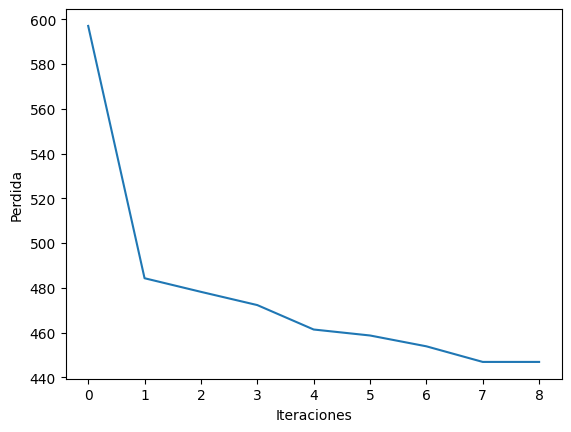

In [184]:
plt.plot(model.losses)
plt.xlabel("Iteraciones")
plt.ylabel("Perdida")
plt.savefig('./KMeans-zoo-loss.png')
plt.show()